In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer
import torch
from transformers import BertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from utils import compute_metrics, explain_sentence
from transformers_interpret import SequenceClassificationExplainer
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

In [4]:
df = pd.read_csv('data/taxi_data_clean.csv')

In [5]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['Sentiment'])  # e.g., 0=Negative, 1=Mixed, 2=Positive

In [6]:
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Reviews'].tolist(),
    df['label'].tolist(),
    test_size=0.2,
    random_state=42
)

In [7]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=256)
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=256)

In [8]:
class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()} | {'labels': torch.tensor(self.labels[idx])}

    def __len__(self):
        return len(self.labels)

train_dataset = ReviewsDataset(train_encodings, train_labels)
val_dataset = ReviewsDataset(val_encodings, val_labels)

In [10]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)

training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to="none" 
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics  
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
c:\Users\Galyna\anaconda3\envs\ml2025\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [11]:
print(trainer.args.device)

cuda:0


In [12]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,Precision Macro,Recall Macro,F1 Macro,F1 Weighted,Roc Auc Ovr
1,No log,0.222012,0.921569,0.639185,0.655000,0.597710,0.905338,0.953838
2,No log,0.185226,0.948529,0.824835,0.794741,0.809133,0.947630,0.963670
3,0.256500,0.218819,0.936275,0.778951,0.803503,0.789384,0.938721,0.966935


TrainOutput(global_step=612, training_loss=0.22590355000464746, metrics={'train_runtime': 273.4799, 'train_samples_per_second': 17.903, 'train_steps_per_second': 2.238, 'total_flos': 644101646598144.0, 'train_loss': 0.22590355000464746, 'epoch': 3.0})

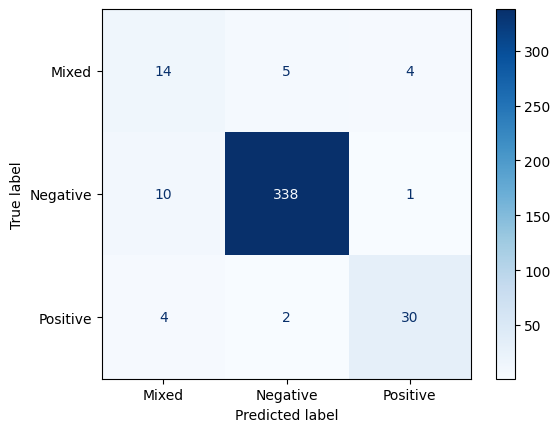

In [13]:
# Get predictions
predictions = trainer.predict(val_dataset)
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

# Plot confusion matrix
cm = confusion_matrix(labels, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.show()

In [14]:
NEG = label_encoder.transform(['Negative'])[0]
POS = label_encoder.transform(['Positive'])[0]

In [15]:
neg_as_pos = (labels == NEG) & (preds == POS)
pos_as_neg = (labels == POS) & (preds == NEG)

In [16]:
pd.set_option('display.max_colwidth', None)
# Negative reviews predicted as Positive
df_neg_as_pos = pd.DataFrame({
    'Review': np.array(val_texts)[neg_as_pos],
    'True Label': label_encoder.inverse_transform(labels[neg_as_pos]),
    'Predicted': label_encoder.inverse_transform(preds[neg_as_pos])
})

# Positive reviews predicted as Negative
df_pos_as_neg = pd.DataFrame({
    'Review': np.array(val_texts)[pos_as_neg],
    'True Label': label_encoder.inverse_transform(labels[pos_as_neg]),
    'Predicted': label_encoder.inverse_transform(preds[pos_as_neg])
})

print("Negative reviews predicted as Positive:")
display(df_neg_as_pos)

print("\n Positive reviews predicted as Negative:")
display(df_pos_as_neg)

Negative reviews predicted as Positive:


,Review,True Label,Predicted
0,"I drive for TaxiDrive in Orlando. My car is always clean, safe and I received a lot of great feedback from passengers. I driven all over Orlando many times very late at night only for TaxiDrive to keep all my earning and display that I owe them. I've had to spend for a lot of gas and tolls, new breaks, tires, deep cleaning because of messes made by some passengers and when I ask where are my earnings I get a bs response. It's as if I been doing favors for people driving them around all for nothing. I'm going to find out who I can talk to so I can file suit again TaxiDrive",Negative,Positive



 Positive reviews predicted as Negative:


,Review,True Label,Predicted
0,"My first experience with TaxiDrive was in San Diego. My wife and I had attended an event at the Union Station and wanted a ride back to our hotel. We called taxi, but the message was that they did not have any vehicles in the area, ""but we could call back in an hour to inquire again."" We then downloaded the TaxiDrive app. and less than 5 minutes later an TaxiDrive was there.",Positive,Negative
1,I am an TaxiDrive driver and have been only for a short time but all the passengers have said positive things about their rides. The company checks out all the riders before they are allowed to use TaxiDrive. It also does a background check of the drivers. They send the driving directions on where to pickup the passengers and also for the destination. Then pay me once a week.,Positive,Negative


In [17]:
explainer = SequenceClassificationExplainer(model, tokenizer)

In [18]:
explain_sentence("I drive for TaxiDrive in Orlando. My car is always clean, safe and I received a lot of great feedback from passengers. I driven all over Orlando many times very late at night only for TaxiDrive to keep all my earning and display that I owe them. I've had to spend for a lot of gas and tolls, new breaks, tires, deep cleaning because of messes made by some passengers and when I ask where are my earnings I get a bs response. It's as if I been doing favors for people driving them around all for nothing. I'm going to find out who I can talk to so I can file suit again TaxiDrive", explainer)


Explanation for: I drive for TaxiDrive in Orlando. My car is always clean, safe and I received a lot of great feedback from passengers. I driven all over Orlando many times very late at night only for TaxiDrive to keep all my earning and display that I owe them. I've had to spend for a lot of gas and tolls, new breaks, tires, deep cleaning because of messes made by some passengers and when I ask where are my earnings I get a bs response. It's as if I been doing favors for people driving them around all for nothing. I'm going to find out who I can talk to so I can file suit again TaxiDrive
deep: 0.3689
suit: 0.2556
nothing: 0.1873
favors: 0.1805
cleaning: 0.1678
again: 0.1591
file: 0.1548
display: 0.1500
is: 0.1452
around: 0.1376
find: 0.1366
i: 0.1264
driven: 0.1223
##drive: 0.1205
get: 0.1096
them: 0.0992
driving: 0.0974
that: 0.0942
orlando: 0.0823
who: 0.0820
clean: 0.0806
great: 0.0800
in: 0.0784
response: 0.0774
people: 0.0760
are: 0.0728
to: 0.0714
keep: 0.0708
for: 0.0705
recei

In [19]:
explain_sentence("My first experience with TaxiDrive was in San Diego. My wife and I had attended an event at the Union Station and wanted a ride back to our hotel. We called taxi, but the message was that they did not have any vehicles in the area, but we could call back in an hour to inquire again. We then downloaded the TaxiDrive app. and less than 5 minutes later an TaxiDrive was there.", explainer)


Explanation for: My first experience with TaxiDrive was in San Diego. My wife and I had attended an event at the Union Station and wanted a ride back to our hotel. We called taxi, but the message was that they did not have any vehicles in the area, but we could call back in an hour to inquire again. We then downloaded the TaxiDrive app. and less than 5 minutes later an TaxiDrive was there.
was: 0.3489
##qui: 0.3382
later: 0.2855
downloaded: 0.2829
an: 0.2756
minutes: 0.1766
but: 0.1710
with: 0.1684
attended: 0.1460
taxi: 0.1430
call: 0.1395
app: 0.1212
##drive: 0.1154
##drive: 0.1090
then: 0.1088
in: 0.1057
back: 0.1047
and: 0.0913
.: 0.0883
.: 0.0852
taxi: 0.0788
could: 0.0781
back: 0.0758
was: 0.0755
experience: 0.0683
not: 0.0611
called: 0.0611
any: 0.0605
san: 0.0594
the: 0.0587
taxi: 0.0579
was: 0.0529
##re: 0.0529
.: 0.0501
##drive: 0.0433
,: 0.0396
vehicles: 0.0373
the: 0.0330
at: 0.0322
in: 0.0311
a: 0.0300
hour: 0.0287
and: 0.0271
there: 0.0266
less: 0.0237
the: 0.0159
an: 0.